In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from sympy.solvers import solve
from sympy import symbols, Matrix
import cv2
from skimage.transform import ProjectiveTransform, warp, SimilarityTransform
import imageio

from PIL import Image

* [Image](http://www.tennisworld.net.au/wp-content/uploads/2013/10/Australian-Open-2012-Rod-Laver2.jpg)
* [Github](https://github.com/matterport/Mask_RCNN)

### Basic Version

In [2]:
def compute_homography(P, plane):
    if plane=='xy':
        H=P[:,[0,1,3]]
    elif plane=='yz':
        H=P[:,[1,2,3]]
    elif plane=='xz':
        H=P[:,[0,2,3]]
    else:
        print("Invalid Plane")

    return H

In [3]:
def compute_scale(V, ref_point, ref_len, world_coord):
    alpha = np.linalg.lstsq( (V-ref_point), (ref_point-world_coord))[0]/ref_len
    return alpha

In [4]:
def compute_vanishing_point(pt11, pt12, pt21, pt22):
    line1 = np.cross(pt11, pt12)
    line2 = np.cross(pt21, pt22)
    V = np.cross(line1, line2)
    V = V / V[2]
    return V

### Case I: Rod Laver Arena (Only court)

In [5]:
im = np.asarray(Image.open('images/Rod-Laver2.jpg'))

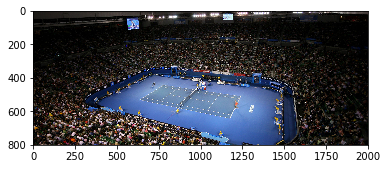

In [6]:
#plt.figure(figsize=(16,8))
plt.imshow(im)
plt.show()

In [7]:
pt11 = np.array([1245.94, 509.90, 1.0])
pt12 = np.array([1176.57, 647.37, 1.0])
pt21 = np.array([780.83, 443.25, 1.0])
pt22 = np.array([637.11, 534.89, 1.0])

VY = compute_vanishing_point(pt11, pt12, pt21, pt22)

In [8]:
pt11 = np.array([1245.94, 509.90, 1.0])
pt12 = np.array([780.83, 443.25, 1.0])
pt21 = np.array([1176.57, 647.37, 1.0])
pt22 = np.array([637.11, 534.89, 1.0])

VX = compute_vanishing_point(pt11, pt12, pt21, pt22)

In [9]:
pt11 = np.array([1352.75, 399.51, 1.0])
pt12 = np.array([1350.48, 435.79, 1.0])
pt21 = np.array([831.18, 347.35, 1.0])
pt22 = np.array([828.91, 376.83, 1.0])

VZ = compute_vanishing_point(pt11, pt12, pt21, pt22)

#### Posts

In [10]:
origin = np.array([878.72, 580.71, 1.0])

ref_Z = np.array([878.72, 553.64, 1.0])
ref_X = np.array([637.11, 534.89, 1.0])
ref_Y = np.array([984.94, 480.74, 1.0])

ref_X_len = np.sqrt((origin[0]-ref_X[0])**2+(origin[1]-ref_X[1])**2)
ref_Y_len = np.sqrt((origin[0]-ref_Y[0])**2+(origin[1]-ref_Y[1])**2)
ref_Z_len = np.sqrt((origin[0]-ref_Z[0])**2+(origin[1]-ref_Z[1])**2)

print("Reference length along Y = {}".format(ref_Y_len))
print("Reference length along X = {}".format(ref_X_len))
print("Reference length along Z = {}".format(ref_Z_len))

Reference length along Y = 145.86531218901914
Reference length along X = 245.91637704715808
Reference length along Z = 27.07000000000005


In [11]:
VX1 = np.transpose(np.reshape(VX, (1, 3)))
VY1 = np.transpose(np.reshape(VY, (1, 3)))
VZ1 = np.transpose(np.reshape(VZ, (1, 3)))
ref_X = np.transpose(np.reshape(ref_X, (1, 3)))
ref_Y = np.transpose(np.reshape(ref_Y, (1, 3)))
ref_Z = np.transpose(np.reshape(ref_Z, (1, 3)))
origin = np.transpose(np.reshape(origin, (1, 3)))

In [12]:
a_x = compute_scale(VX1, ref_X, ref_X_len, origin)
a_y = compute_scale(VY1, ref_Y, ref_Y_len, origin)
a_z = compute_scale(VZ1, ref_Z, ref_Z_len, origin)

print ("Scaling constant a_x = {}".format(a_x))
print ("Scaling constant a_y = {}".format(a_y))
print ("Scaling constant a_z = {}".format(a_z))

Scaling constant a_x = [[0.00056865]]
Scaling constant a_y = [[0.00136254]]
Scaling constant a_z = [[2.71899428e-05]]


/Users/bydottck13/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [13]:
a_VX = a_x*np.array(VX1)
b_VY = a_y*np.array(VY1)
c_VZ = a_z*np.array(VZ1)
origin = np.array(origin)

P = np.concatenate((a_VX, b_VY, c_VZ, origin), axis=1)
print('Projection Matrix\n {}'.format(P))

Projection Matrix
 [[-6.16495153e-01  2.06584977e+00  9.87354263e-02  8.78720000e+02]
 [ 1.00082027e-01 -3.49207537e-02 -9.79313340e-01  5.80710000e+02]
 [ 5.68646952e-04  1.36253747e-03  2.71899428e-05  1.00000000e+00]]


In [14]:
HXY = compute_homography(P, 'xy')
HYZ = compute_homography(P, 'yz')
HXZ = compute_homography(P, 'xz')
print('HXY=\n {}'.format(HXY))
print('HYZ=\n {}'.format(HYZ))
print('HXZ=\n {}'.format(HXZ))

HXY=
 [[-6.16495153e-01  2.06584977e+00  8.78720000e+02]
 [ 1.00082027e-01 -3.49207537e-02  5.80710000e+02]
 [ 5.68646952e-04  1.36253747e-03  1.00000000e+00]]
HYZ=
 [[ 2.06584977e+00  9.87354263e-02  8.78720000e+02]
 [-3.49207537e-02 -9.79313340e-01  5.80710000e+02]
 [ 1.36253747e-03  2.71899428e-05  1.00000000e+00]]
HXZ=
 [[-6.16495153e-01  9.87354263e-02  8.78720000e+02]
 [ 1.00082027e-01 -9.79313340e-01  5.80710000e+02]
 [ 5.68646952e-04  2.71899428e-05  1.00000000e+00]]


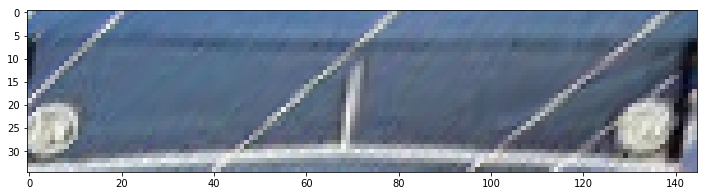

In [15]:
tform = ProjectiveTransform(matrix=HYZ)

image0_zeros = warp(im, tform, output_shape=(35, 145, 3))

plt.figure(figsize=(12,12))
plt.imshow(image0_zeros)
plt.show()

imageio.imwrite('tennis_xz.png', (np.flip(image0_zeros, 0)*255).astype(np.uint8))

#### Court 

In [16]:
origin = np.array([1176.57, 647.36, 1.0])

ref_Z = np.array([1176.57, 620.36, 1.0])
ref_Y = np.array([1245.3, 509.9, 1.0])
ref_X = np.array([637.11, 534.89, 1.0])

ref_X_len = np.sqrt((origin[0]-ref_X[0])**2+(origin[1]-ref_X[1])**2)
ref_Y_len = np.sqrt((origin[0]-ref_Y[0])**2+(origin[1]-ref_Y[1])**2)
ref_Z_len = np.sqrt((origin[0]-ref_Z[0])**2+(origin[1]-ref_Z[1])**2)

print("Reference length along Y = {}".format(ref_Y_len))
print("Reference length along X = {}".format(ref_X_len))
print("Reference length along Z = {}".format(ref_Z_len))

Reference length along Y = 153.68495209356058
Reference length along X = 551.0595181103398
Reference length along Z = 27.0


In [17]:
VX1 = np.transpose(np.reshape(VX, (1, 3)))
VY1 = np.transpose(np.reshape(VY, (1, 3)))
VZ1 = np.transpose(np.reshape(VZ, (1, 3)))
ref_X = np.transpose(np.reshape(ref_X, (1, 3)))
ref_Y = np.transpose(np.reshape(ref_Y, (1, 3)))
ref_Z = np.transpose(np.reshape(ref_Z, (1, 3)))
origin = np.transpose(np.reshape(origin, (1, 3)))

In [18]:
a_x = compute_scale(VX1, ref_X, ref_X_len, origin)
a_y = compute_scale(VY1, ref_Y, ref_Y_len, origin)
a_z = compute_scale(VZ1, ref_Z, ref_Z_len, origin)

print ("Scaling constant a_x = {}".format(a_x))
print ("Scaling constant a_y = {}".format(a_y))
print ("Scaling constant a_z = {}".format(a_z))

Scaling constant a_x = [[0.00056874]]
Scaling constant a_y = [[0.00166626]]
Scaling constant a_z = [[2.71722046e-05]]


/Users/bydottck13/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [19]:
a_VX = a_x*np.array(VX1)
b_VY = a_y*np.array(VY1)
c_VZ = a_z*np.array(VZ1)
origin = np.array(origin)

P = np.concatenate((a_VX, b_VY, c_VZ, origin), axis=1)
print('Projection Matrix\n {}'.format(P))

Projection Matrix
 [[-6.16596609e-01  2.52635218e+00  9.86710131e-02  1.17657000e+03]
 [ 1.00098498e-01 -4.27050037e-02 -9.78674454e-01  6.47360000e+02]
 [ 5.68740534e-04  1.66626323e-03  2.71722046e-05  1.00000000e+00]]


In [20]:
HXY = compute_homography(P, 'xy')
HYZ = compute_homography(P, 'yz')
HXZ = compute_homography(P, 'xz')
print('HXY=\n {}'.format(HXY))
print('HYZ=\n {}'.format(HYZ))
print('HXZ=\n {}'.format(HXZ))

HXY=
 [[-6.16596609e-01  2.52635218e+00  1.17657000e+03]
 [ 1.00098498e-01 -4.27050037e-02  6.47360000e+02]
 [ 5.68740534e-04  1.66626323e-03  1.00000000e+00]]
HYZ=
 [[ 2.52635218e+00  9.86710131e-02  1.17657000e+03]
 [-4.27050037e-02 -9.78674454e-01  6.47360000e+02]
 [ 1.66626323e-03  2.71722046e-05  1.00000000e+00]]
HXZ=
 [[-6.16596609e-01  9.86710131e-02  1.17657000e+03]
 [ 1.00098498e-01 -9.78674454e-01  6.47360000e+02]
 [ 5.68740534e-04  2.71722046e-05  1.00000000e+00]]


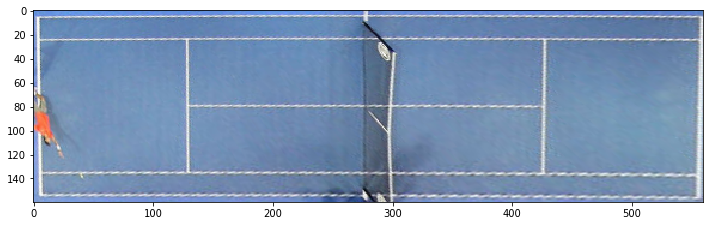

In [21]:
tform = ProjectiveTransform(matrix=HXY)

image0_zeros = warp(im, tform, output_shape=(160, 560, 3))

plt.figure(figsize=(12,12))
plt.imshow(image0_zeros)
plt.show()

imageio.imwrite('tennis_xy.png', (np.transpose(image0_zeros*255, (1, 0, 2)).astype(np.uint8)))

#### Case II: Rod Laver Arena (the whole area)
* Compute the new origin by vanishing points

In [87]:
new_y = np.array([1397.35, 487.58, 1.0])
new_x = np.array([532.62, 555.32, 1.0])
new_line_x = np.cross(VX, new_x)
new_line_y = np.cross(VY, new_y)
origin = np.cross(new_line_x, new_line_y)
origin = origin/origin[2]
print('new origin {}'.format(origin))

new origin [1.33791918e+03 7.44256581e+02 1.00000000e+00]


In [88]:
new_z = origin + np.array([0.0, -60.0, 0.0])
print('new z {}'.format(new_z))

new z [1.33791918e+03 6.84256581e+02 1.00000000e+00]


In [89]:
ref_X_len = np.sqrt((origin[0]-new_x[0])**2+(origin[1]-new_x[1])**2)
ref_Y_len = np.sqrt((origin[0]-new_y[0])**2+(origin[1]-new_y[1])**2)
ref_Z_len = np.sqrt((origin[0]-new_z[0])**2+(origin[1]-new_z[1])**2)

print("Reference length along Y = {}".format(ref_Y_len))
print("Reference length along X = {}".format(ref_X_len))
print("Reference length along Z = {}".format(ref_Z_len))

Reference length along Y = 263.46705625386164
Reference length along X = 827.1661238907086
Reference length along Z = 60.0


In [90]:
VX1 = np.transpose(np.reshape(VX, (1, 3)))
VY1 = np.transpose(np.reshape(VY, (1, 3)))
VZ1 = np.transpose(np.reshape(VZ, (1, 3)))
ref_X = np.transpose(np.reshape(ref_X, (1, 3)))
ref_Y = np.transpose(np.reshape(ref_Y, (1, 3)))
ref_Z = np.transpose(np.reshape(ref_Z, (1, 3)))
origin = np.transpose(np.reshape(origin, (1, 3)))

In [91]:
a_x = compute_scale(VX1, ref_X, ref_X_len, origin)
a_y = compute_scale(VY1, ref_Y, ref_Y_len, origin)
a_z = compute_scale(VZ1, ref_Z, ref_Z_len, origin)

print ("Scaling constant a_x = {}".format(a_x))
print ("Scaling constant a_y = {}".format(a_y))
print ("Scaling constant a_z = {}".format(a_z))

Scaling constant a_x = [[0.0005011]]
Scaling constant a_y = [[0.00105822]]
Scaling constant a_z = [[5.12133177e-05]]


/Users/bydottck13/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [92]:
a_VX = a_x*np.array(VX1)
b_VY = a_y*np.array(VY1)
c_VZ = a_z*np.array(VZ1)
origin = np.array(origin)

P = np.concatenate((a_VX, b_VY, c_VZ, origin), axis=1)
print('Projection Matrix\n {}'.format(P))

Projection Matrix
 [[-5.43263727e-01  1.60444416e+00  1.85972026e-01  1.33791918e+03]
 [ 8.81936132e-02 -2.71212361e-02 -1.84457487e+00  7.44256581e+02]
 [ 5.01099256e-04  1.05821601e-03  5.12133177e-05  1.00000000e+00]]


In [93]:
HXY = compute_homography(P, 'xy')
HYZ = compute_homography(P, 'yz')
HXZ = compute_homography(P, 'xz')
print('HXY=\n {}'.format(HXY))
print('HYZ=\n {}'.format(HYZ))
print('HXZ=\n {}'.format(HXZ))

HXY=
 [[-5.43263727e-01  1.60444416e+00  1.33791918e+03]
 [ 8.81936132e-02 -2.71212361e-02  7.44256581e+02]
 [ 5.01099256e-04  1.05821601e-03  1.00000000e+00]]
HYZ=
 [[ 1.60444416e+00  1.85972026e-01  1.33791918e+03]
 [-2.71212361e-02 -1.84457487e+00  7.44256581e+02]
 [ 1.05821601e-03  5.12133177e-05  1.00000000e+00]]
HXZ=
 [[-5.43263727e-01  1.85972026e-01  1.33791918e+03]
 [ 8.81936132e-02 -1.84457487e+00  7.44256581e+02]
 [ 5.01099256e-04  5.12133177e-05  1.00000000e+00]]


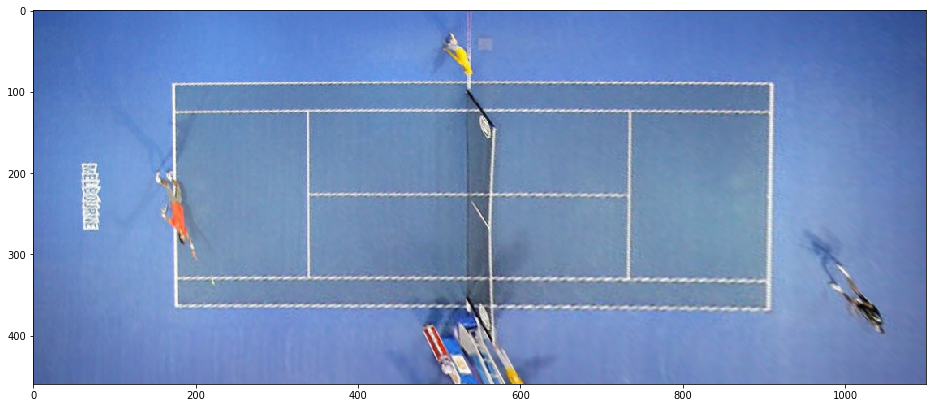

In [94]:
tform = ProjectiveTransform(matrix=HXY)
image0_zeros = warp(im, tform, output_shape=(460, 1100, 3))

plt.figure(figsize=(16,8))
plt.imshow(image0_zeros)
plt.show()

imageio.imwrite('tennis_xy_big.png', (np.transpose(image0_zeros*255, (1, 0, 2)).astype(np.uint8)))

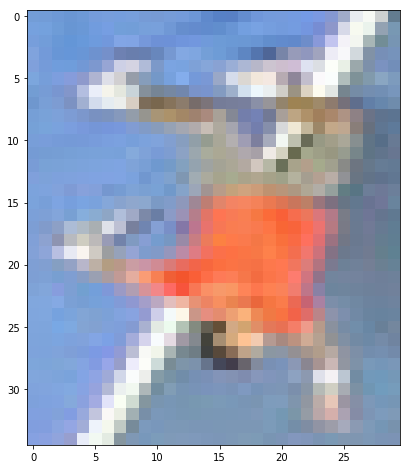

In [104]:
tform = ProjectiveTransform(matrix=HXZ)
image0_zeros = warp(im, tform, output_shape=(300, 1100, 3))

plt.figure(figsize=(16,8))
plt.imshow(image0_zeros[70:105, 100:130])
plt.show()

imageio.imwrite('tennis_person.png', (image0_zeros[70:105, 100:130]*255).astype(np.uint8))

### Improved Version (by Mask R-CNN)
* Use Mask R-CNN to detect the keypoints
* Use these keypoints to compute vanishing points
* Use vanishing points to estimate the center point
* Use all points to reconstruct the 3D view

In [105]:
import os
import sys
import random
import math
import skimage.io
import matplotlib
from scipy import signal
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
MODEL_DIR = './log'
COCO_MODEL_PATH = './mask_rcnn_coco.h5'
%matplotlib inline

Using TensorFlow backend.


In [106]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [107]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Processing 1 images
image                    shape: (551, 735, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


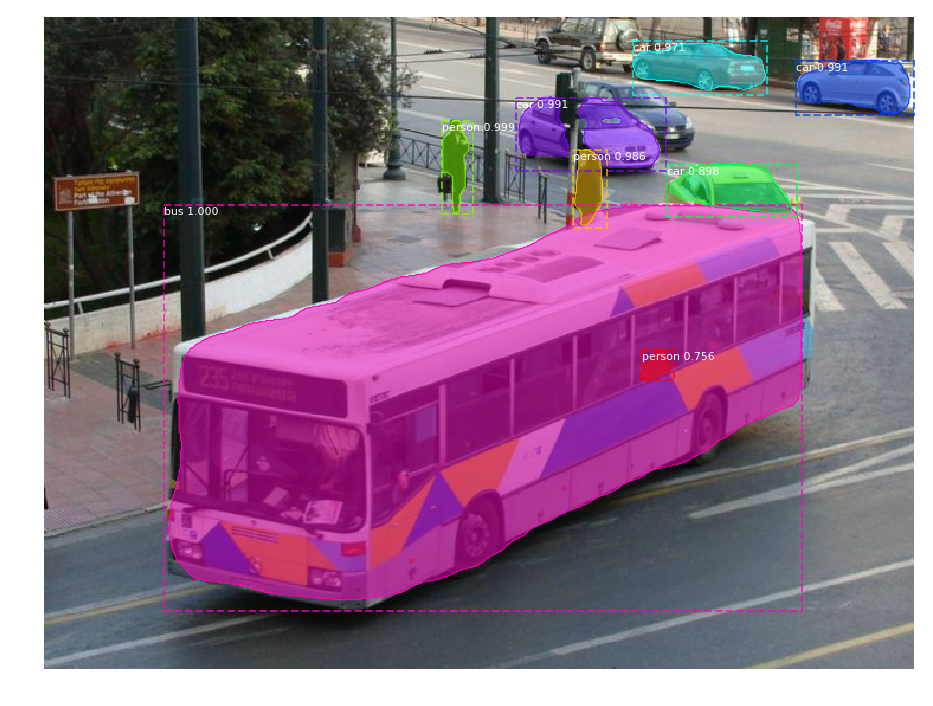

In [108]:
image = skimage.io.imread("./bus.jpg")
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

#### Point Detection

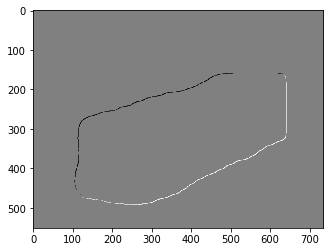

In [109]:
# edge kernel
img = r['masks'][:,:,0]
gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])
gy = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]])
grad_x = signal.convolve2d(img, gx, boundary='symm', mode='same')
grad_y = signal.convolve2d(img, gy, boundary='symm', mode='same')
gg = grad_x + grad_y
plt.imshow(gg, cmap='gray')
plt.show()

In [110]:
def detect_down_left(img):
    col = -1
    # iter_col
    for i in range(0, img.shape[1]-1):
        tmp = img[:, i]
        next_tmp = img[:, i+1]
        if any(list(filter(lambda x: x>0, next_tmp))) and not any(list(filter(lambda x: x>0, tmp))):
            col = i+1
            break
    
    row = -1
    for i in range(img.shape[0]-1, -1, -1):
        if img[i, col] != 0:
            row = i
            break
    return (row, col)

In [111]:
def detect_up_left(img):
    col = -1
    # iter_col
    for i in range(0, img.shape[1]-1):
        tmp = img[:, i]
        next_tmp = img[:, i+1]
#         if sum(list(map(lambda x: x<0, next_tmp))) != 0:
#             print(sum(list(map(lambda x: x<0, next_tmp))))
        if sum(list(map(lambda x: x<0, tmp))) - sum(list(map(lambda x: x<0, next_tmp))) >= 5 and sum(list(map(lambda x: x<0, next_tmp))) <= 10:
            col = i+1
            break
    
    row = -1
    for i in range(0, img.shape[0]):
        if img[i, col] != 0:
            row = i
            break
    return (row, col)

In [112]:
def detect_upper(img):
    for i in range(img.shape[0]):
        if any(list(filter(lambda x: x != 0, img[i, :]))):
            for j in range(img.shape[1]):
                if img[i, j] != 0:
                    return (i, j)

In [113]:
def detect_lower(img):
    for i in range(img.shape[0]-1, -1, -1):
        if any(list(filter(lambda x: x != 0, img[i, :]))):
            for j in range(img.shape[1]):
                if img[i, j] != 0:
                    return (i, j)

In [114]:
def detect_down_right(img):
    col = -1
    # iter_col
    for i in range(img.shape[1]-1, 0, -1):
        tmp = img[:, i]
        next_tmp = img[:, i-1]
#         if sum(list(map(lambda x: x>0, next_tmp))) != 0:
#             print(sum(list(map(lambda x: x>0, next_tmp))))
        if sum(list(map(lambda x: x>0, tmp))) - sum(list(map(lambda x: x>0, next_tmp))) >= 5 and sum(list(map(lambda x: x>0, next_tmp))) <= 10:
            col = i - 1
            break
    
    row = -1
    for i in range(img.shape[0]-1, -1, -1):
        if img[i, col] != 0:
            row = i
            break
    return (row, col)

In [115]:
def detect_up_right(img):
    col = -1
    # iter_col
    for i in range(img.shape[1]-1, 0, -1):
        tmp = img[:, i]
        next_tmp = img[:, i-1]
        if any(list(filter(lambda x: x<0, next_tmp))) and not any(list(filter(lambda x: x<0, tmp))):
            col = i-1
            break
    
    row = -1
    for i in range(img.shape[0]):
        if img[i, col] < 0:
            row = i
            break
    return (row, col)

In [116]:
print('down left', detect_down_left(gg))
print('up left', detect_up_left(gg))
print('upper', detect_upper(gg))
print('lower', detect_lower(gg))
print('down right', detect_down_right(gg))
print('up right', detect_up_right(gg))

down left (459, 112)
up left (287, 117)
upper (158, 504)
lower (492, 244)
down right (325, 636)
up right (161, 632)


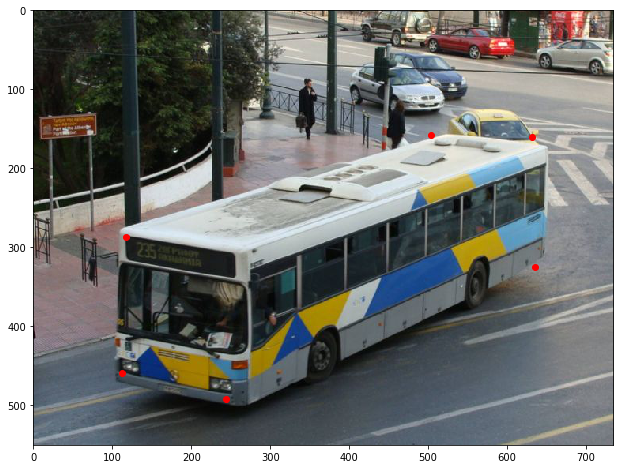

In [117]:
points = [detect_down_left(gg), detect_up_left(gg), detect_upper(gg), detect_lower(gg), detect_down_right(gg), detect_up_right(gg)]

plt.figure(figsize=(16,8))
plt.imshow(image)
for pt in points:
    plt.plot(pt[1], pt[0], 'ro')
plt.show()

#### Compute the center point 

In [118]:
pt_long_11 = np.array([points[1][1], points[1][0], 1.0])
pt_long_12 = np.array([points[2][1], points[2][0], 1.0])
pt_long_21 = np.array([points[3][1], points[3][0], 1.0])
pt_long_22 = np.array([points[4][1], points[4][0], 1.0])

VX = compute_vanishing_point(pt_long_11, pt_long_12, pt_long_21, pt_long_22)
print(VX)

[ 2.91247706e+03 -6.44825688e+02  1.00000000e+00]


In [119]:
pt_long_11 = np.array([points[5][1], points[5][0], 1.0])
pt_long_12 = np.array([points[2][1], points[2][0], 1.0])
pt_long_21 = np.array([points[3][1], points[3][0], 1.0])
pt_long_22 = np.array([points[0][1], points[0][0], 1.0])

VY = compute_vanishing_point(pt_long_11, pt_long_12, pt_long_21, pt_long_22)
print(VY)

[-1.25710345e+03  1.16724138e+02  1.00000000e+00]


In [120]:
pt_long_11 = np.array([points[5][1], points[5][0], 1.0])
pt_long_12 = np.array([points[4][1], points[4][0], 1.0])
pt_long_21 = np.array([points[1][1], points[1][0], 1.0])
pt_long_22 = np.array([points[0][1], points[0][0], 1.0])

VZ = compute_vanishing_point(pt_long_11, pt_long_12, pt_long_21, pt_long_22)
print(VZ)

[ 3.98710875e+02 -9.40385411e+03  1.00000000e+00]


In [121]:
line1 = np.cross(VX, np.array([points[5][1], points[5][0], 1.0]))
line2 = np.cross(VY, np.array([points[1][1], points[1][0], 1.0]))

pt_cnt = np.cross(line1, line2)
pt_cnt = pt_cnt / pt_cnt[2]
print(pt_cnt)

[234.28967521 301.5342773    1.        ]


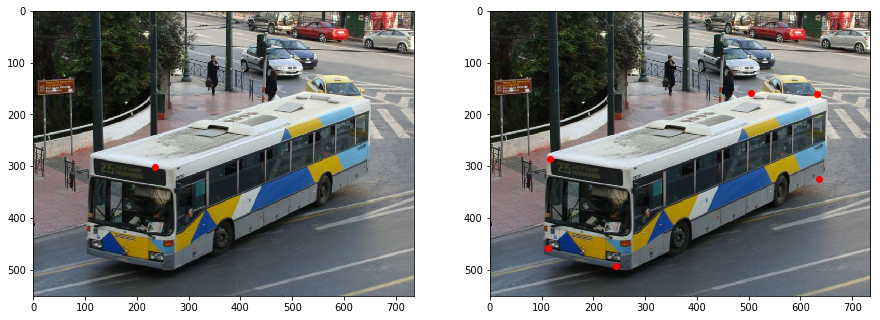

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax[0].imshow(image)
ax[0].plot(pt_cnt[0], pt_cnt[1], 'ro')
ax[1].imshow(image)
for pt in points:
    ax[1].plot(pt[1], pt[0], 'ro')
plt.show()

In [123]:
origin = np.array([points[3][1], points[3][0], 1.0])

ref_Z = pt_cnt
ref_X = np.array([points[4][1], points[4][0], 1.0])
ref_Y = np.array([points[0][1], points[0][0], 1.0])

ref_X_len = np.sqrt((origin[0]-ref_X[0])**2+(origin[1]-ref_X[1])**2)
ref_Y_len = np.sqrt((origin[0]-ref_Y[0])**2+(origin[1]-ref_Y[1])**2)
ref_Z_len = np.sqrt((origin[0]-ref_Z[0])**2+(origin[1]-ref_Z[1])**2)

print("Reference length along Y = {}".format(ref_Y_len))
print("Reference length along X = {}".format(ref_X_len))
print("Reference length along Z = {}".format(ref_Z_len))

Reference length along Y = 136.0624856453828
Reference length along X = 426.09036600233054
Reference length along Z = 190.7130879889691


In [124]:
VX = np.transpose(np.reshape(VX, (1, 3)))
VY = np.transpose(np.reshape(VY, (1, 3)))
VZ = np.transpose(np.reshape(VZ, (1, 3)))
ref_X = np.transpose(np.reshape(ref_X, (1, 3)))
ref_Y = np.transpose(np.reshape(ref_Y, (1, 3)))
ref_Z = np.transpose(np.reshape(ref_Z, (1, 3)))
origin = np.transpose(np.reshape(origin, (1, 3)))

In [125]:
a_x = compute_scale(VX, ref_X, ref_X_len, origin)
a_y = compute_scale(VY, ref_Y, ref_Y_len, origin)
a_z = compute_scale(VZ, ref_Z, ref_Z_len, origin)

print ("Scaling constant a_x = {}".format(a_x))
print ("Scaling constant a_y = {}".format(a_y))
print ("Scaling constant a_z = {}".format(a_z))

Scaling constant a_x = [[0.00040413]]
Scaling constant a_y = [[0.0007086]]
Scaling constant a_z = [[0.00010278]]


/Users/bydottck13/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [126]:
a_VX = a_x*np.array(VX)
b_VY = a_y*np.array(VY)
c_VZ = a_z*np.array(VZ)
origin = np.array(origin)

P = np.concatenate((a_VX, b_VY, c_VZ, origin), axis=1)
print('Projection Matrix\n {}'.format(P))

Projection Matrix
 [[ 1.17701931e+00 -8.90779644e-01  4.09809106e-02  2.44000000e+02]
 [-2.60593395e-01  8.27103658e-02 -9.66561308e-01  4.92000000e+02]
 [ 4.04129983e-04  7.08596930e-04  1.02783529e-04  1.00000000e+00]]


In [127]:
HXY = compute_homography(P, 'xy')
HYZ = compute_homography(P, 'yz')
HXZ = compute_homography(P, 'xz')
print('HXY=\n {}'.format(HXY))
print('HYZ=\n {}'.format(HYZ))
print('HXZ=\n {}'.format(HXZ))

HXY=
 [[ 1.17701931e+00 -8.90779644e-01  2.44000000e+02]
 [-2.60593395e-01  8.27103658e-02  4.92000000e+02]
 [ 4.04129983e-04  7.08596930e-04  1.00000000e+00]]
HYZ=
 [[-8.90779644e-01  4.09809106e-02  2.44000000e+02]
 [ 8.27103658e-02 -9.66561308e-01  4.92000000e+02]
 [ 7.08596930e-04  1.02783529e-04  1.00000000e+00]]
HXZ=
 [[ 1.17701931e+00  4.09809106e-02  2.44000000e+02]
 [-2.60593395e-01 -9.66561308e-01  4.92000000e+02]
 [ 4.04129983e-04  1.02783529e-04  1.00000000e+00]]


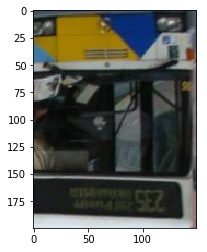

In [134]:
tform = ProjectiveTransform(matrix=HYZ)

image0_zeros = warp(image, tform, output_shape=(200, 150, 3))
    
plt.imshow(image0_zeros)
plt.show()

imageio.imwrite('bus_yz.png', (np.flip(image0_zeros*225, 1).astype(np.uint8)))

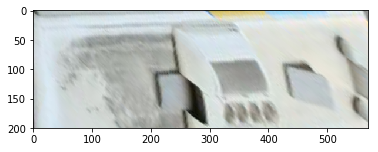

In [129]:
tform = ProjectiveTransform(matrix=HXY)

image0_zeros = warp(image, tform, output_shape=(600, 1000, 3))
    
plt.imshow(image0_zeros[330:530,370:940])
plt.show()

imageio.imwrite('bus_xy.png', (np.transpose(image0_zeros[330:530,370:940]*255, (1, 0, 2))).astype(np.uint8))

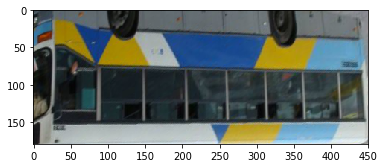

In [130]:
tform = ProjectiveTransform(matrix=HXZ)

image0_zeros = warp(image, tform, output_shape=(180, 450, 3))
    
plt.imshow(image0_zeros)
plt.show()

imageio.imwrite('bus_xz.png', (image0_zeros*225).astype(np.uint8))